<a href="https://colab.research.google.com/github/DhrubaAdhikary/ERA_V2/blob/master/S21_unet/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet


## Install Dependencies

In [1]:
# !pip install torchinfo --quiet

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/DhrubaAdhikary/ERA_V2.git -q --quiet
!mv ERA_V2/S21_unet/* .
!rm -rf ERA_V2
print("Loaded Modules and Models")

# For inline matplotlib plotting
%matplotlib inline

Loaded Modules and Models


## Import Dependencies

In [4]:
# Standard Library Imports
import os
import sys

# Third-Party Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary

# from google.colab import drive
# drive.mount('/content/drive')



In [5]:
# import sys
# if 'google.colab' in sys.modules:
# # Add the directory containing your module to the Python path
#   module_path = '/content/drive/MyDrive/Colab_Notebooks/Session21-unet'
#   sys.path.append(module_path)
#   print(sys.path)

In [6]:
# %cd  /content/drive/MyDrive/Colab_Notebooks/Session-21-unet

In [7]:
from utils import tensor_trimap, args_to_dict, display_loss_and_accuracies, display_output
from dataset import OxfordIIITPetsAugmented
from model import UNet
from training_utils import train, test, dice_loss

## Dataset Preparation

In [8]:
transform_dict = args_to_dict(
    pre_transform=transforms.ToTensor(),
    pre_target_transform=transforms.ToTensor(),

    common_transform=transforms.Compose([
        transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    ]),

    post_transform=transforms.Compose([
        transforms.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=transforms.Compose([
        transforms.Lambda(tensor_trimap),
    ]),
)

In [9]:
train_dataset = OxfordIIITPetsAugmented(
    root='./data/OxfordPets/train',
    split="trainval",
    target_types="segmentation",
    download=True,
    **transform_dict,
)

test_dataset = OxfordIIITPetsAugmented(
    root='./data/OxfordPets/test',
    split="test",
    target_types="segmentation",
    download=True,
    **transform_dict,
)

100%|██████████| 791918971/791918971 [00:47<00:00, 16531102.79it/s]


Extracting data/OxfordPets/train/oxford-iiit-pet/images.tar.gz to data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 6864363.24it/s] 


Extracting data/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:48<00:00, 16332610.21it/s]


Extracting data/OxfordPets/test/oxford-iiit-pet/images.tar.gz to data/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 6736919.98it/s] 


Extracting data/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to data/OxfordPets/test/oxford-iiit-pet


## DataLoader Preparation

In [10]:
SEED = 8
BATCH_SIZE = 16

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=False, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

# Test DataLoader
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

CUDA Available? True


## Visualize Data

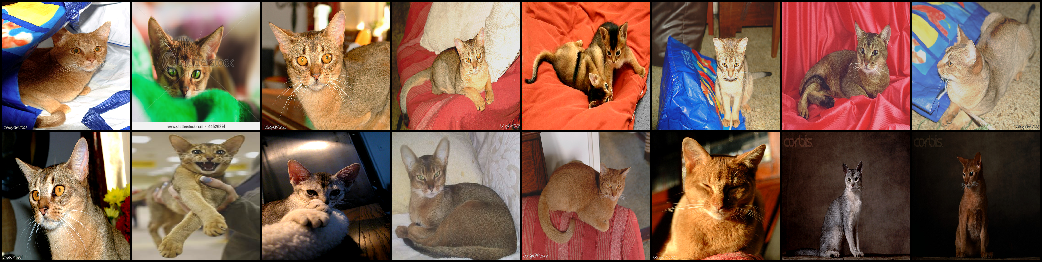

In [11]:
# Convert a pytorch tensor into a PIL image
t2img = transforms.ToPILImage()

train_pets_inputs, train_pets_targets = next(iter(train_loader))

pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

## Visualize Masks

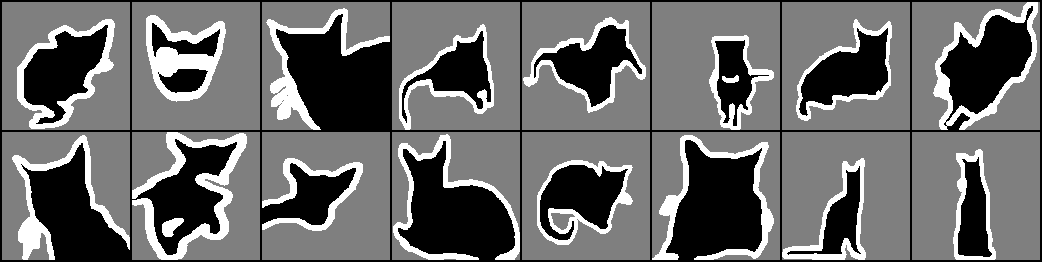

In [12]:
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

## Training Parameters

In [13]:
EPOCHS = 20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-5

## Training Run

In [14]:
def train_session(model, loss):
    """
    Function to train the model
    """
    # Data to plot accuracy and loss graphs
    train_losses = []
    test_losses = []

    # Optimization algorithm to update the weights
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Scheduler to change the learning rate after specific number of epochs
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)
    scheduler = None

    # CE OR Dice Loss
    criterion = loss

    # For each epoch
    for epoch in range(1, EPOCHS+1):
        print(" ")
        print(f'Epoch {epoch}')

        # Train the model on training dataset and append the training loss and accuracy
        train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
        train_losses.append(train_loss / len(train_loader))

        # Test the model's performance on test dataset and append the training loss and accuracy
        test_loss = test(model, device, test_loader, criterion)
        test_losses.append(test_loss)

    display_loss_and_accuracies(train_losses, test_losses)

---

## 1. Model Training - MaxPool + Transpose + Cross Entropy Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.6279 Batch_id=229: 100%|██████████| 230/230 [00:41<00:00,  5.52it/s]


Test set: Average loss: 0.6858
 
Epoch 2


Train: Loss=0.5649 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.38it/s]


Test set: Average loss: 0.6754
 
Epoch 3


Train: Loss=0.5528 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.40it/s]


Test set: Average loss: 0.6155
 
Epoch 4


Train: Loss=0.5332 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.46it/s]


Test set: Average loss: 0.6073
 
Epoch 5


Train: Loss=0.4949 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.46it/s]


Test set: Average loss: 0.5611
 
Epoch 6


Train: Loss=0.5074 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.44it/s]


Test set: Average loss: 0.5507
 
Epoch 7


Train: Loss=0.4705 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.5041
 
Epoch 8


Train: Loss=0.4162 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.33it/s]


Test set: Average loss: 0.4830
 
Epoch 9


Train: Loss=0.3863 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.4451
 
Epoch 10


Train: Loss=0.3699 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.4309
 
Epoch 11


Train: Loss=0.3506 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.4230
 
Epoch 12


Train: Loss=0.3395 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.43it/s]


Test set: Average loss: 0.4013
 
Epoch 13


Train: Loss=0.3307 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.43it/s]


Test set: Average loss: 0.3857
 
Epoch 14


Train: Loss=0.3107 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.3896
 
Epoch 15


Train: Loss=0.3212 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.3800
 
Epoch 16


Train: Loss=0.3060 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.40it/s]


Test set: Average loss: 0.3701
 
Epoch 17


Train: Loss=0.2932 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.35it/s]


Test set: Average loss: 0.3694
 
Epoch 18


Train: Loss=0.2989 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.32it/s]


Test set: Average loss: 0.3862
 
Epoch 19


Train: Loss=0.2817 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.40it/s]


Test set: Average loss: 0.3885
 
Epoch 20


Train: Loss=0.2552 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.3869


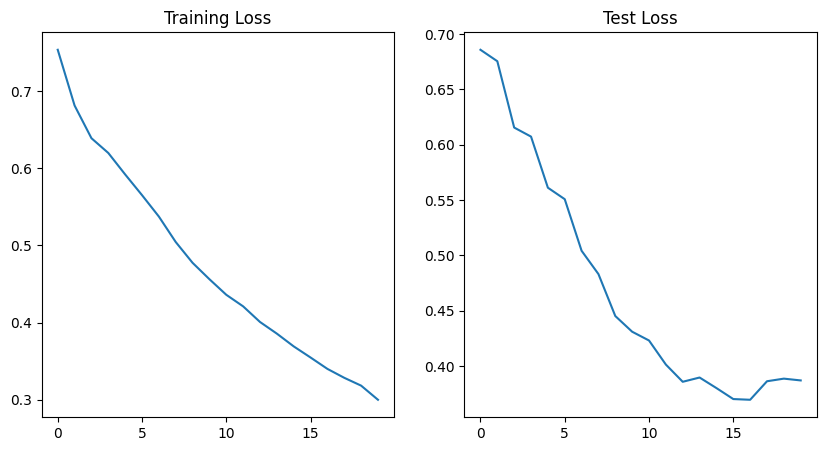

In [15]:
model = UNet(3, 3)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# CE Loss
criterion = nn.CrossEntropyLoss()

train_session(model, criterion)

---

## 2. Model Training - MaxPool + Transpose + Dice Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.4548 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.5415
 
Epoch 2


Train: Loss=0.4581 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.40it/s]


Test set: Average loss: 0.4138
 
Epoch 3


Train: Loss=0.3776 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.43it/s]


Test set: Average loss: 0.4232
 
Epoch 4


Train: Loss=0.4099 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.3759
 
Epoch 5


Train: Loss=0.3804 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.3442
 
Epoch 6


Train: Loss=0.3865 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.3309
 
Epoch 7


Train: Loss=0.3571 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.3171
 
Epoch 8


Train: Loss=0.3240 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.3109
 
Epoch 9


Train: Loss=0.2908 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.2935
 
Epoch 10


Train: Loss=0.2874 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.2780
 
Epoch 11


Train: Loss=0.3233 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.40it/s]


Test set: Average loss: 0.2857
 
Epoch 12


Train: Loss=0.3068 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.2671
 
Epoch 13


Train: Loss=0.2747 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.41it/s]


Test set: Average loss: 0.2897
 
Epoch 14


Train: Loss=0.2601 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.42it/s]


Test set: Average loss: 0.2672
 
Epoch 15


Train: Loss=0.2604 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.40it/s]


Test set: Average loss: 0.2471
 
Epoch 16


Train: Loss=0.2668 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.2524
 
Epoch 17


Train: Loss=0.2342 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.32it/s]


Test set: Average loss: 0.2420
 
Epoch 18


Train: Loss=0.2233 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.30it/s]


Test set: Average loss: 0.2540
 
Epoch 19


Train: Loss=0.2013 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.32it/s]


Test set: Average loss: 0.2474
 
Epoch 20


Train: Loss=0.2410 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.30it/s]


Test set: Average loss: 0.2380


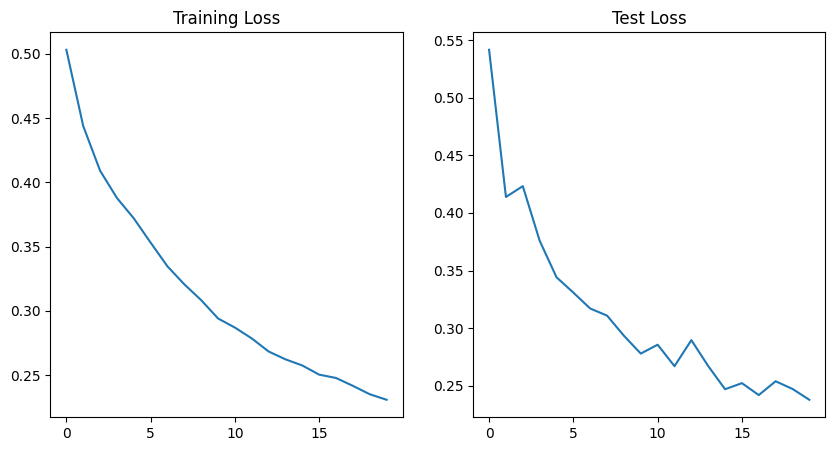

In [16]:
model = UNet(3, 3)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# Dice Loss
criterion = dice_loss

train_session(model, criterion)

---

## 3. Model Training - Strided Convolution + Transpose + Cross Entropy Loss

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.6525 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.17it/s]


Test set: Average loss: 0.7031
 
Epoch 2


Train: Loss=0.6067 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.18it/s]


Test set: Average loss: 0.6720
 
Epoch 3


Train: Loss=0.5561 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.18it/s]


Test set: Average loss: 0.6570
 
Epoch 4


Train: Loss=0.4967 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.20it/s]


Test set: Average loss: 0.6490
 
Epoch 5


Train: Loss=0.5003 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.25it/s]


Test set: Average loss: 0.7275
 
Epoch 6


Train: Loss=0.4688 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.24it/s]


Test set: Average loss: 0.5607
 
Epoch 7


Train: Loss=0.4613 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.23it/s]


Test set: Average loss: 0.5557
 
Epoch 8


Train: Loss=0.4550 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.23it/s]


Test set: Average loss: 0.5179
 
Epoch 9


Train: Loss=0.4157 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.22it/s]


Test set: Average loss: 0.4946
 
Epoch 10


Train: Loss=0.3982 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.24it/s]


Test set: Average loss: 0.5040
 
Epoch 11


Train: Loss=0.3917 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.22it/s]


Test set: Average loss: 0.4863
 
Epoch 12


Train: Loss=0.3887 Batch_id=229: 100%|██████████| 230/230 [00:43<00:00,  5.23it/s]


Test set: Average loss: 0.4690
 
Epoch 13


Train: Loss=0.3565 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.21it/s]


Test set: Average loss: 0.4590
 
Epoch 14


Train: Loss=0.3516 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.22it/s]


Test set: Average loss: 0.4278
 
Epoch 15


Train: Loss=0.3345 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.19it/s]


Test set: Average loss: 0.4222
 
Epoch 16


Train: Loss=0.3145 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.17it/s]


Test set: Average loss: 0.4006
 
Epoch 17


Train: Loss=0.3157 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.15it/s]


Test set: Average loss: 0.4013
 
Epoch 18


Train: Loss=0.2911 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.15it/s]


Test set: Average loss: 0.3898
 
Epoch 19


Train: Loss=0.2929 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.13it/s]


Test set: Average loss: 0.3813
 
Epoch 20


Train: Loss=0.2885 Batch_id=229: 100%|██████████| 230/230 [00:44<00:00,  5.18it/s]


Test set: Average loss: 0.3783


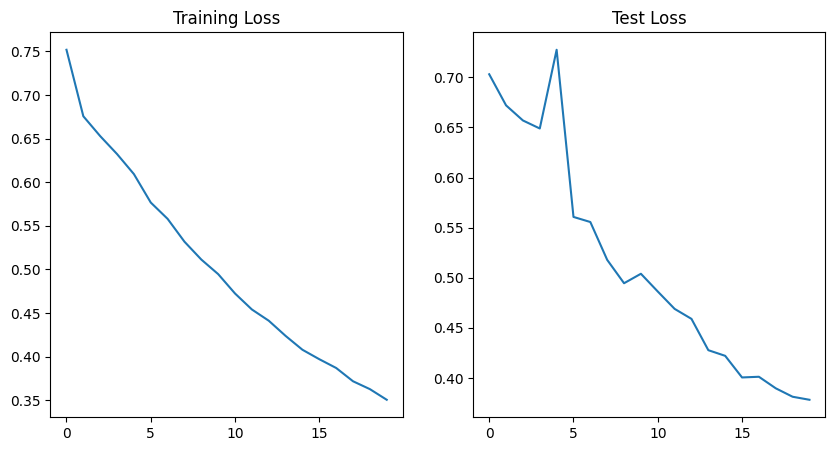

In [17]:
model = UNet(3, 3, max_pool=False)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# CE Loss
criterion = nn.CrossEntropyLoss()

train_session(model, criterion)

---

## 4. Model Training - Strided Convolution + Upsampling + Dice Loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.4635 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.95it/s]


Test set: Average loss: 0.4689
 
Epoch 2


Train: Loss=0.4303 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.94it/s]


Test set: Average loss: 0.4038
 
Epoch 3


Train: Loss=0.3776 Batch_id=229: 100%|██████████| 230/230 [00:47<00:00,  4.86it/s]


Test set: Average loss: 0.3747
 
Epoch 4


Train: Loss=0.3391 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.91it/s]


Test set: Average loss: 0.3680
 
Epoch 5


Train: Loss=0.3291 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.94it/s]


Test set: Average loss: 0.3478
 
Epoch 6


Train: Loss=0.3567 Batch_id=229: 100%|██████████| 230/230 [00:47<00:00,  4.86it/s]


Test set: Average loss: 0.3398
 
Epoch 7


Train: Loss=0.3339 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.91it/s]


Test set: Average loss: 0.3374
 
Epoch 8


Train: Loss=0.3324 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.94it/s]


Test set: Average loss: 0.3260
 
Epoch 9


Train: Loss=0.3589 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


Test set: Average loss: 0.3239
 
Epoch 10


Train: Loss=0.2933 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.90it/s]


Test set: Average loss: 0.2949
 
Epoch 11


Train: Loss=0.2617 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.93it/s]


Test set: Average loss: 0.3048
 
Epoch 12


Train: Loss=0.2404 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.92it/s]


Test set: Average loss: 0.2778
 
Epoch 13


Train: Loss=0.2242 Batch_id=229: 100%|██████████| 230/230 [00:47<00:00,  4.85it/s]


Test set: Average loss: 0.2675
 
Epoch 14


Train: Loss=0.2281 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.93it/s]


Test set: Average loss: 0.2669
 
Epoch 15


Train: Loss=0.2317 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.92it/s]


Test set: Average loss: 0.2697
 
Epoch 16


Train: Loss=0.2358 Batch_id=229: 100%|██████████| 230/230 [00:47<00:00,  4.86it/s]


Test set: Average loss: 0.2632
 
Epoch 17


Train: Loss=0.2336 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.94it/s]


Test set: Average loss: 0.2569
 
Epoch 18


Train: Loss=0.2159 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.93it/s]


Test set: Average loss: 0.2547
 
Epoch 19


Train: Loss=0.2068 Batch_id=229: 100%|██████████| 230/230 [00:47<00:00,  4.87it/s]


Test set: Average loss: 0.2496
 
Epoch 20


Train: Loss=0.1938 Batch_id=229: 100%|██████████| 230/230 [00:46<00:00,  4.92it/s]


Test set: Average loss: 0.2521


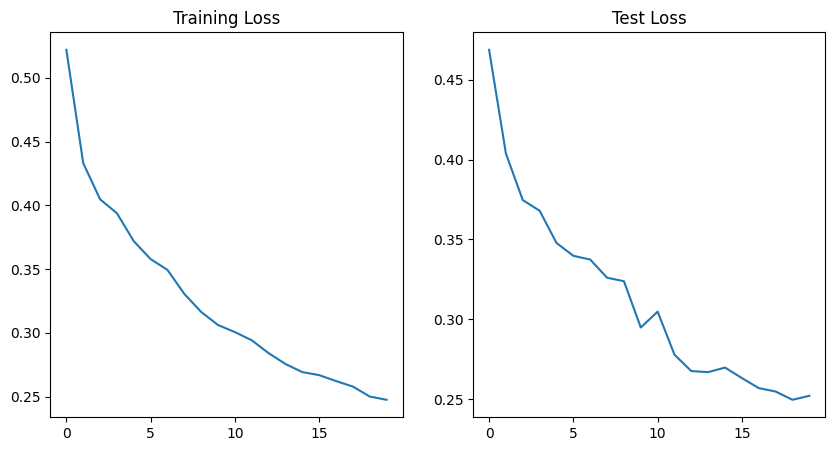

In [18]:
model = UNet(3, 3, max_pool=False, transpose=False)
model = model.to('cuda')
summary(model, input_size=(3, 128, 128))

# Dice Loss
criterion = dice_loss

train_session(model, criterion)

---

## Model Predictions

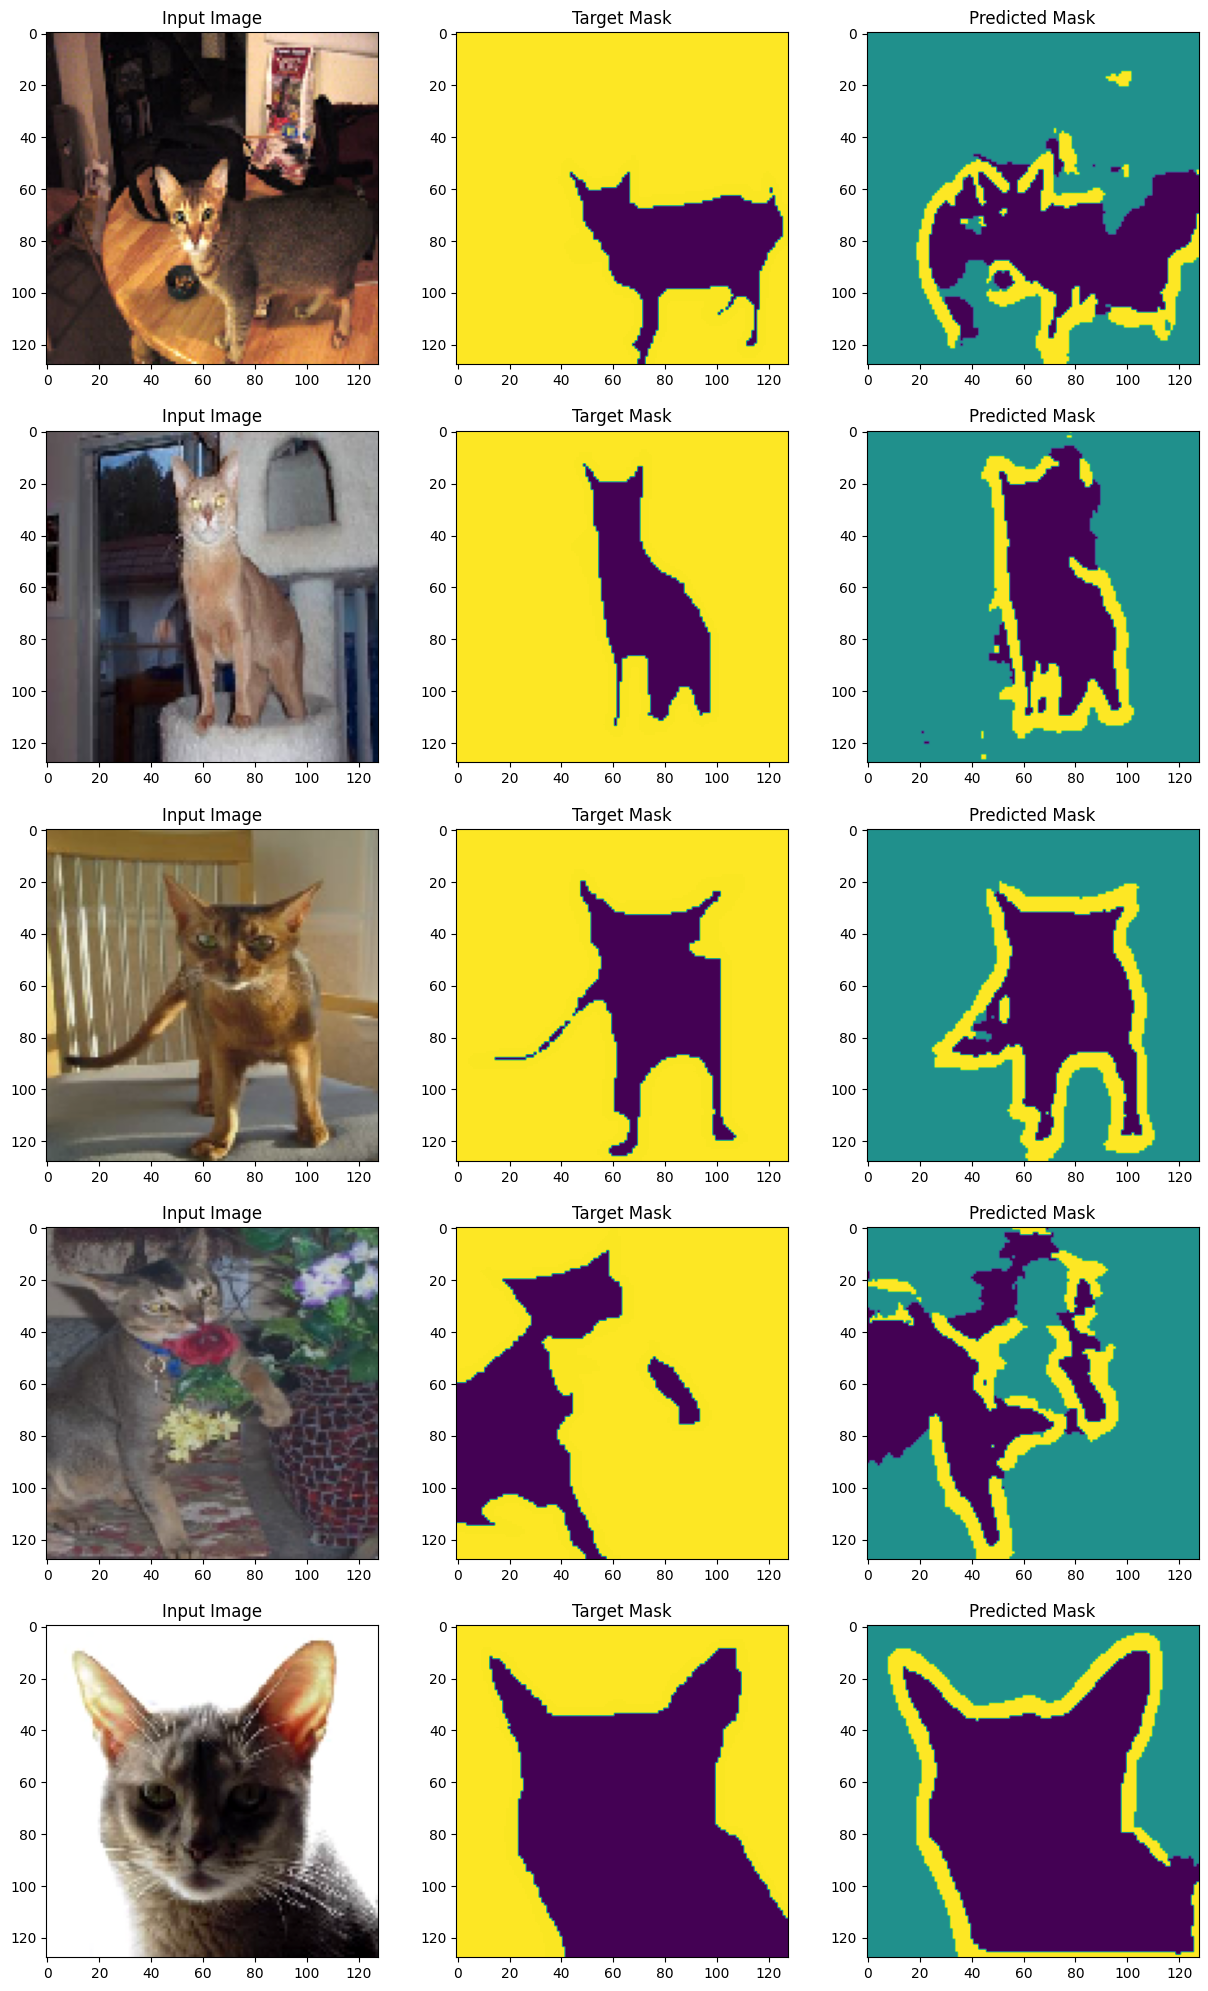

In [19]:
display_output(model, test_loader)

## Save the Model

In [20]:
torch.save(model.state_dict(), 'UNet.pth')